### Read in all CTD data

In [2]:
import pandas as pd
from glob import glob
import gsw
import numpy as np
from geopy.distance import distance
from extraFuncs import zmld_boyer # this is the mixed layer depth function

df2012 = pd.read_csv('../data/acousticData/2012_2013/Arctic_EIS_Acoustic_trawl_survey_alongtrack_summary_2012_v3.csv')
df2013 = pd.read_csv('../data/acousticData/2012_2013/Arctic_EIS_Acoustic_trawl_survey_alongtrack_summary_2013_v3.csv')
df2012Acoustics = df2012.iloc[:, [0,1,2,3,4]]
df2013Acoustics = df2013.iloc[:, [0,1,2,3,4]]
df2018Acoustics = pd.read_csv('../data/acousticData/2017_2019/Arctic_EIS_Acoustic_trawl_survey_alongtrack_summary_2017.csv')
df2017Acoustics = pd.read_csv('../data/acousticData/2018/Arctic_EIS_Acoustic_trawl_survey_alongtrack_summary_2018.csv')
df2017Acoustics = df2017Acoustics[df2017Acoustics.Latitude!=999]
df2019Acoustics = pd.read_csv('../data/acousticData/2017_2019/Arctic_EIS_Acoustic_trawl_survey_alongtrack_summary_2019.csv')
df2019Acoustics = df2019Acoustics[df2019Acoustics.Latitude!=999]

df2012Catch = df2012.iloc[:, [1,2,3,6,7,8,9,10]]
df2013Catch = df2013.iloc[:, [1,2,3,6,7,8,9,10]]
df2017Catch = pd.read_csv('../data/catchData/2017_2019/Arctic_EIS_Acoustic_trawl_survey_alongtrack_summary_2017.csv')
df2017Catch = df2017Catch[df2017Catch.Latitude!=999]
df2019Catch = pd.read_csv('../data/catchData/2017_2019/Arctic_EIS_Acoustic_trawl_survey_alongtrack_summary_2019.csv')
df2019Catch = df2019Catch[df2019Catch.Latitude!=999]

dfCTD = pd.concat([pd.read_csv(file) for file in glob('../data/physicalData/*.csv')])
dfCTD = dfCTD[dfCTD['profile_id'].notna()]
dfCTD = dfCTD.drop(labels=['S_42'],axis=1)
dfCTD = dfCTD.astype({'pressure': float, 'latitude': float, 'longitude': float, 'S_41': float, 'T2_35': float,'T_28': float})
dfCTD['time'] = pd.to_datetime(dfCTD.time)
dfCTD['depth'] = -1*gsw.z_from_p(dfCTD.pressure, dfCTD.latitude)
dfCTD = dfCTD.sort_values(by='time')
dfCTD2017 = dfCTD[(dfCTD.time.dt.year == 2017) & (((dfCTD.time > pd.to_datetime('8-10-2017').tz_localize ('UTC')) &(dfCTD.time < pd.to_datetime('8-12-2017').tz_localize ('UTC')))| (dfCTD.time > pd.to_datetime('8-27-2017').tz_localize ('UTC')))]
dfCTD2019 = dfCTD[(dfCTD.time.dt.year == 2019) & (dfCTD.time > pd.to_datetime('8-27-2019').tz_localize ('UTC'))]
dfCTD_clean = pd.concat([dfCTD2017,dfCTD2019])

dfAIES = pd.read_csv('../data/physicalData/Chukchi12_13ctd.csv')
dfStat2012 = dfAIES[(dfAIES.StationID.str.contains("2012")) & (dfAIES.MAST_Latdd >=66)].rename(columns={'MAST_Latdd':'latitude','MAST_Longdd':'longitude','Temp.surf':'T_surf','Sal.surf':'S_surf','Temp.bot':'T_bot','Sal.bot':'S_bot'})
dfStat2013 = dfAIES[(dfAIES.StationID.str.contains("2013")) & (dfAIES.MAST_Latdd >=66)].rename(columns={'MAST_Latdd':'latitude','MAST_Longdd':'longitude','Temp.surf':'T_surf','Sal.surf':'S_surf','Temp.bot':'T_bot','Sal.bot':'S_bot'})
dfAIES_clean = pd.concat([dfStat2012,dfStat2013])

### Read in the acoustic data and get mwd

In [ ]:
dfSurveys = pd.read_csv('../data/acousticData/2017_2019/mbaIntegrationResults.csv')
dfSurveys = dfSurveys[dfSurveys.CLASS!= 'SURFTURB']
df2017 = dfSurveys[dfSurveys.SURVEY==201701]
df2019 = dfSurveys[dfSurveys.SURVEY==201901]

def mwd(df):
    df['depth'] = (df.LAYER*5)-2.5
    df['weightedSA'] =df.PRC_NASC*df.depth
    df = df.groupby(['INTERVAL',"END_LONGITUDE", "END_LATITUDE","END_TIME"])[["PRC_NASC", "weightedSA"]].sum()
    df['mwd'] = df.weightedSA/df.PRC_NASC
    df = df.reset_index()
    df = df.drop(columns='weightedSA')
    df = df.rename(columns = {'END_LONGITUDE':'Longitude','END_LATITUDE':'Latitude'})
    df = df[df.Latitude!=999]
    return df

df2017mwd = mwd(df2017)
df2019mwd = mwd(df2019)

### CTD gridding

In [263]:
def ctdStationRadius(df1):
    dfStations = df1[['profile_id','latitude','longitude','time']].drop_duplicates(subset = ['profile_id'])
    dfs = []
    for year in [2017,2019]:
        if year == 2017:
            df = dfStations[dfStations.time.dt.year == year]
            df['latitude'] = df.latitude.apply(lambda x:np.round(x,1))
            df['longitude'] = df.longitude.apply(lambda x:np.round(x,1))
            df = df[['profile_id','latitude','longitude','time']].drop_duplicates(subset=['latitude', 'longitude'])
            df = df[df.latitude != 71.2] 
            dfs.append(df)
        else:
            df = dfStations[dfStations.time.dt.year == year]
            df['latitude'] = df.latitude.apply(lambda x:np.round(x,2))
            df['longitude'] = df.longitude.apply(lambda x:np.round(x,2))
            df = df[['profile_id','latitude','longitude','time']].drop_duplicates(subset=['latitude', 'longitude'])
            dfs.append(df)
    dfStations = pd.concat(dfs)
    dfs = []
    for year in df1.time.dt.year.unique():
        dists = []
        dfCur = dfStations[dfStations.time.dt.year == year]
        nPoints = len(dfCur.latitude)
        for i in range(nPoints):
            curDists = []
            for ii in range(nPoints):
                if ii == i:
                    continue
                curDists.append(distance((dfCur.latitude.values[i],dfCur.longitude.values[i]),(dfCur.latitude.values[ii],dfCur.longitude.values[ii])).nm)
            dists.append(np.min(curDists))
        dfCur['TrackRadius'] = np.array(dists)/2
        dfs.append(dfCur)
    dfStations = pd.concat(dfs)
        
    
    S_max, S_min, S_surf, S_bot, S_mean, T_min, T_max, T_surf, T_bot, T_mean,mld,Depth_max = [[] for i in range(12)]
    for pid in dfStations.profile_id.unique():
        dfCur = df1[(df1.profile_id==pid)].sort_values('pressure')
        S_max.append(dfCur.S_41.max())
        S_min.append(dfCur.S_41.min())
        S_surf.append(dfCur[dfCur.depth < 10].S_41.mean())
        S_bot.append(dfCur[dfCur.depth > dfCur.depth.max()-5].S_41.mean())
        S_mean.append(dfCur.S_41.mean())
        T_max.append(dfCur.T_28.max())
        T_min.append(dfCur.T_28.min())
        T_surf.append(dfCur[dfCur.depth < 10].T_28.mean())
        T_bot.append(dfCur[dfCur.depth > dfCur.depth.max()-5].T_28.mean())
        T_mean.append(dfCur.T_28.mean())
        Depth_max.append(dfCur.depth.max())
        try:
            mld1, mld2 = zmld_boyer(dfCur.dropna().S_41.values, dfCur.dropna().T_28.values, dfCur.dropna().pressure.values)
        except:
            print(pid)
            mld2 = np.nan
        mld.append(mld2)
    dfStations['Year'] = dfStations.time.dt.year
    dfStats = pd.DataFrame({'profile_id':dfStations.profile_id.unique(),'Depth_max':Depth_max,'S_max':S_max, 'S_min':S_min, 'S_surf':S_surf, 'S_bot':S_bot,'S_mean':S_mean, 'T_min':T_min, 'T_max':T_max, 'T_surf':T_surf, 'T_bot':T_bot,'T_mean':T_mean,'MLD':mld})
    return dfStations.merge(dfStats)

def ctdStationRadiusOld(dfEnv):
    dists = []
    for dfEnvCur in [dfEnv[dfEnv.Year == 2012],dfEnv[dfEnv.Year == 2013]]:
        nPoints = len(dfEnvCur.latitude)
        for i in range(nPoints):
            curDists = []
            for ii in range(nPoints):
                if ii == i:
                    continue
                curDists.append(distance((dfEnvCur.latitude.values[i],dfEnvCur.longitude.values[i]),(dfEnvCur.latitude.values[ii],dfEnvCur.longitude.values[ii])).nm)
            dists.append(np.min(curDists))
    dfEnv['TrackRadius'] = np.array(dists)/2
    dfEnv = dfEnv.drop(axis = 1,labels=['phi5','DIN.surf','DIN.bot','MeanStrat','IntChla','TOC'])
    dfEnv['time'] = dfEnv.Year.apply(lambda x: pd.to_datetime(str(x)+'-1-1',format='%Y-%m-%d'))
    dfEnv = dfEnv.rename(columns = {'StationID':'profile_id'})
    return dfEnv

In [267]:
from tqdm import tqdm_notebook as tqdm
dfStatN = ctdStationRadius(dfCTD_clean)
dfStatOld = ctdStationRadiusOld(dfAIES_clean)
dfStat = pd.concat([dfStatN,dfStatOld])

meanSa, meanAcod, meanScod, meanPcod, meanPol,meanCap = ([] for i in range(6))
for  year in dfStat.Year.unique():
    dfEnvCur = dfStat[dfStat.Year == year]
    if year == 2017:
        dfFish = df2017Catch
        dfAcoustics = df2017Acoustics
    elif year == 2019:
        dfFish = df2019Catch
        dfAcoustics = df2019Acoustics
    elif year == 2012:
        dfFish = df2012Catch
        dfAcoustics = df2012Acoustics
    elif year == 2013:
        dfFish = df2013Catch
        dfAcoustics = df2013Acoustics
    for i in tqdm(range(len(dfEnvCur))):
        curSa, curAcod, curScod, curPcod, curPol,curCap = [[] for k in range(6)]
        curSite = (dfEnvCur.latitude.values[i],dfEnvCur.longitude.values[i])        
        curRad = dfEnvCur.TrackRadius.values[i]
        for ii in range(len(dfFish)):
            if distance(curSite,(dfFish.Latitude.values[ii],dfFish.Longitude.values[ii])).nm <= curRad:
                curAcod.append(dfFish['Arctic cod (No. m^-2)'].values[ii])
                #curScod.append(dfFish['Saffron cod (No. m^-2)'].values[ii])
                #curPcod.append(dfFish['Pacific cod (No. m^-2)'].values[ii])
                curPol.append(dfFish['Pollock (No. m^-2)'].values[ii])
                curCap.append(dfFish['Capelin (No. m^-2)'].values[ii])
        for ii in range(len(dfAcoustics)):
            if distance(curSite,(dfAcoustics.Latitude.values[ii],dfAcoustics.Longitude.values[ii])).nm <= curRad:
                curSa.append(dfAcoustics['Fish 38 kHz sA (m^2 nmi^-2)'].values[ii])
        meanSa.append(np.nanmean(curSa))
        meanAcod.append(np.nanmean(curAcod))
        #meanScod.append(np.nanmean(curScod))
        #meanPcod.append(np.nanmean(curPcod))
        meanPol.append(np.nanmean(curPol))
        meanCap.append(np.nanmean(curCap))
dfStat['meanSa'] = meanSa
dfStat['meanAcod'] = meanAcod
#dfStat['meanScod'] = meanScod
#dfStat['meanPcod'] = meanPcod
dfStat['meanPol'] = meanPol
dfStat['meanCap'] = meanCap
dfStat.to_csv('catchAnalysis/analysisFiles/dfStat.csv')

<ipython-input-263-d5ad0057f9a5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latitude'] = df.latitude.apply(lambda x:np.round(x,1))
<ipython-input-263-d5ad0057f9a5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['longitude'] = df.longitude.apply(lambda x:np.round(x,1))
<ipython-input-263-d5ad0057f9a5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

<ipython-input-267-10c419afdb49>:35: RuntimeWarning: Mean of empty slice
  meanSa.append(np.nanmean(curSa))
<ipython-input-267-10c419afdb49>:36: RuntimeWarning: Mean of empty slice
  meanAcod.append(np.nanmean(curAcod))
<ipython-input-267-10c419afdb49>:39: RuntimeWarning: Mean of empty slice
  meanPol.append(np.nanmean(curPol))
<ipython-input-267-10c419afdb49>:40: RuntimeWarning: Mean of empty slice
  meanCap.append(np.nanmean(curCap))


<ipython-input-267-10c419afdb49>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(dfEnvCur))):


<ipython-input-267-10c419afdb49>:35: RuntimeWarning: Mean of empty slice
  meanSa.append(np.nanmean(curSa))
<ipython-input-267-10c419afdb49>:36: RuntimeWarning: Mean of empty slice
  meanAcod.append(np.nanmean(curAcod))
<ipython-input-267-10c419afdb49>:39: RuntimeWarning: Mean of empty slice
  meanPol.append(np.nanmean(curPol))
<ipython-input-267-10c419afdb49>:40: RuntimeWarning: Mean of empty slice
  meanCap.append(np.nanmean(curCap))


<ipython-input-267-10c419afdb49>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(dfEnvCur))):


<ipython-input-267-10c419afdb49>:35: RuntimeWarning: Mean of empty slice
  meanSa.append(np.nanmean(curSa))
<ipython-input-267-10c419afdb49>:36: RuntimeWarning: Mean of empty slice
  meanAcod.append(np.nanmean(curAcod))
<ipython-input-267-10c419afdb49>:39: RuntimeWarning: Mean of empty slice
  meanPol.append(np.nanmean(curPol))
<ipython-input-267-10c419afdb49>:40: RuntimeWarning: Mean of empty slice
  meanCap.append(np.nanmean(curCap))


<ipython-input-267-10c419afdb49>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(dfEnvCur))):


<ipython-input-267-10c419afdb49>:35: RuntimeWarning: Mean of empty slice
  meanSa.append(np.nanmean(curSa))
<ipython-input-267-10c419afdb49>:36: RuntimeWarning: Mean of empty slice
  meanAcod.append(np.nanmean(curAcod))
<ipython-input-267-10c419afdb49>:39: RuntimeWarning: Mean of empty slice
  meanPol.append(np.nanmean(curPol))
<ipython-input-267-10c419afdb49>:40: RuntimeWarning: Mean of empty slice
  meanCap.append(np.nanmean(curCap))


In [3]:
dfStat = pd.read_csv('catchAnalysis/analysisFiles/dfStat.csv')
dfStat['time'] = pd.to_datetime(dfStat.time)
dfStat2017 = dfStat[dfStat.Year == 2017]
dfStat2019 = dfStat[dfStat.Year == 2019]
dfStat2012 = dfStat[dfStat.Year == 2012]
dfStat2013 = dfStat[dfStat.Year == 2013]

Text(0.5, 1.0, 'All Years')

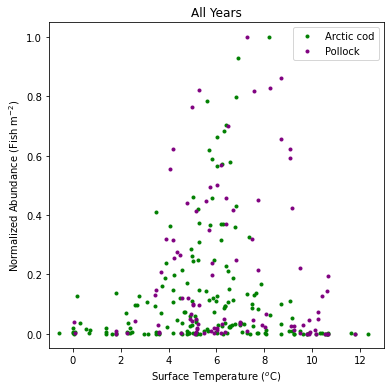

In [52]:
fig = plt.figure(figsize=(6,6))
plt.plot(dfStat[dfStat.meanAcod >0].T_surf.values,dfStat[dfStat.meanAcod >0].meanAcod.values/dfStat[dfStat.meanAcod >0].meanAcod.max(),'.',color = 'green')
plt.plot(dfStat[dfStat.meanPol >0].T_surf.values,dfStat[dfStat.meanPol >0].meanPol.values,'.',color='purple')
plt.xlim(-1,13)
plt.ylabel('Normalized Abundance (Fish m$^{-2}$)')
plt.xlabel('Surface Temperature ($^{o}$C)')
plt.legend(['Arctic cod','Pollock'])
plt.title('All Years')

Text(0.5, 1.0, '2019')

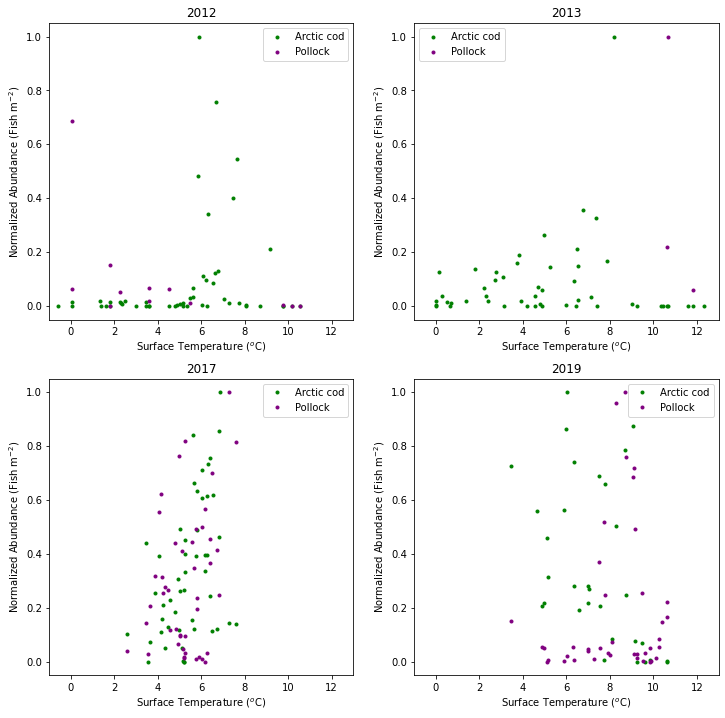

In [51]:
fig = plt.figure(figsize=(12,12))
plt.subplot(221)
plt.plot(dfStat2012[dfStat2012.meanAcod >0].T_surf.values,dfStat2012[dfStat2012.meanAcod >0].meanAcod.values/dfStat2012[dfStat2012.meanAcod >0].meanAcod.max(),'.',color = 'green')
plt.plot(dfStat2012[dfStat2012.meanPol >0].T_surf.values,dfStat2012[dfStat2012.meanPol >0].meanPol.values/dfStat2012[dfStat2012.meanPol >0].meanPol.max(),'.',color='purple')
plt.xlim(-1,13)
plt.ylabel('Normalized Abundance (Fish m$^{-2}$)')
plt.xlabel('Surface Temperature ($^{o}$C)')
plt.legend(['Arctic cod','Pollock'])
plt.title('2012')
plt.subplot(222)
plt.plot(dfStat2013[dfStat2013.meanAcod >0].T_surf.values,dfStat2013[dfStat2013.meanAcod >0].meanAcod.values/dfStat2013[dfStat2013.meanAcod >0].meanAcod.max(),'.',color = 'green')
plt.plot(dfStat2013[dfStat2013.meanPol >0].T_surf.values,dfStat2013[dfStat2013.meanPol >0].meanPol.values/dfStat2013[dfStat2013.meanPol >0].meanPol.max(),'.',color='purple')
plt.xlim(-1,13)
plt.ylabel('Normalized Abundance (Fish m$^{-2}$)')
plt.xlabel('Surface Temperature ($^{o}$C)')
plt.legend(['Arctic cod','Pollock'])
plt.title('2013')
plt.subplot(223)
plt.plot(dfStat2017[dfStat2017.meanAcod >0].T_surf.values,dfStat2017[dfStat2017.meanAcod >0].meanAcod.values/dfStat2017[dfStat2017.meanAcod >0].meanAcod.max(),'.',color = 'green')
plt.plot(dfStat2017[dfStat2017.meanPol >0].T_surf.values,dfStat2017[dfStat2017.meanPol >0].meanPol.values/dfStat2017[dfStat2017.meanPol >0].meanPol.max(),'.',color='purple')
plt.xlim(-1,13)
plt.ylabel('Normalized Abundance (Fish m$^{-2}$)')
plt.xlabel('Surface Temperature ($^{o}$C)')
plt.legend(['Arctic cod','Pollock'])
plt.title('2017')
plt.subplot(224)
plt.plot(dfStat2019[dfStat2019.meanAcod >0].T_surf.values,dfStat2019[dfStat2019.meanAcod >0].meanAcod.values/dfStat2019[dfStat2019.meanAcod >0].meanAcod.max(),'.',color = 'green')
plt.plot(dfStat2019[dfStat2019.meanPol >0].T_surf.values,dfStat2019[dfStat2019.meanPol >0].meanPol.values/dfStat2019[dfStat2019.meanPol >0].meanPol.max(),'.',color='purple')
plt.xlim(-1,13)
plt.ylabel('Normalized Abundance (Fish m$^{-2}$)')
plt.xlabel('Surface Temperature ($^{o}$C)')
plt.legend(['Arctic cod','Pollock'])
plt.title('2019')

C:\Users\rober\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


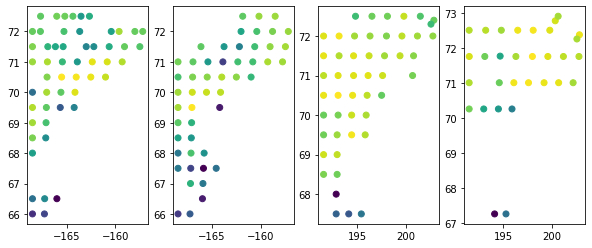

In [6]:
import matplotlib.pyplot as plt
fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4,figsize=(10,4))
ax1.scatter(dfStat2012.longitude, dfStat2012.latitude, c=np.log(dfStat2012.meanAcod))
ax2.scatter(dfStat2013.longitude, dfStat2013.latitude, c=np.log(dfStat2013.meanAcod))
ax3.scatter(dfStat2017.longitude, dfStat2017.latitude, c=np.log(dfStat2017.meanAcod))
ax4.scatter(dfStat2019.longitude, dfStat2019.latitude, c=np.log(dfStat2019.meanAcod))

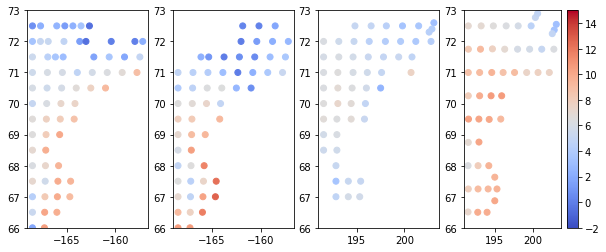

In [5]:
fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4,figsize=(10,4))
ax1.scatter(dfStat2012.longitude, dfStat2012.latitude, c=dfStat2012.T_surf,vmin=-2,vmax=15,cmap='coolwarm')
ax1.set_ylim(66,73)
a = ax2.scatter(dfStat2013.longitude, dfStat2013.latitude, c=dfStat2013.T_surf,vmin=-2,vmax=15,cmap='coolwarm')
ax2.set_ylim(66,73)
ax3.scatter(dfStat2017.longitude, dfStat2017.latitude, c=dfStat2017.T_surf,vmin=-2,vmax=15,cmap='coolwarm')
ax3.set_ylim(66,73)
a = ax4.scatter(dfStat2019.longitude, dfStat2019.latitude, c=dfStat2019.T_surf,vmin=-2,vmax=15,cmap='coolwarm')
ax4.set_ylim(66,73)
plt.colorbar(a)

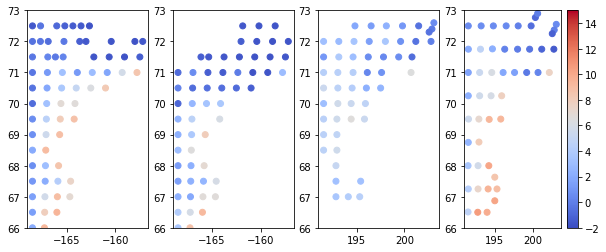

In [282]:
fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4,figsize=(10,4))
ax1.scatter(dfStat2012.longitude, dfStat2012.latitude, c=dfStat2012.T_bot,vmin=-2,vmax=15,cmap='coolwarm')
ax1.set_ylim(66,73)
a = ax2.scatter(dfStat2013.longitude, dfStat2013.latitude, c=dfStat2013.T_bot,vmin=-2,vmax=15,cmap='coolwarm')
ax2.set_ylim(66,73)
ax3.scatter(dfStat2017.longitude, dfStat2017.latitude, c=dfStat2017.T_bot,vmin=-2,vmax=15,cmap='coolwarm')
ax3.set_ylim(66,73)
a = ax4.scatter(dfStat2019.longitude, dfStat2019.latitude, c=dfStat2019.T_bot,vmin=-2,vmax=15,cmap='coolwarm')
ax4.set_ylim(66,73)
plt.colorbar(a)

C:\Users\rober\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\rober\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


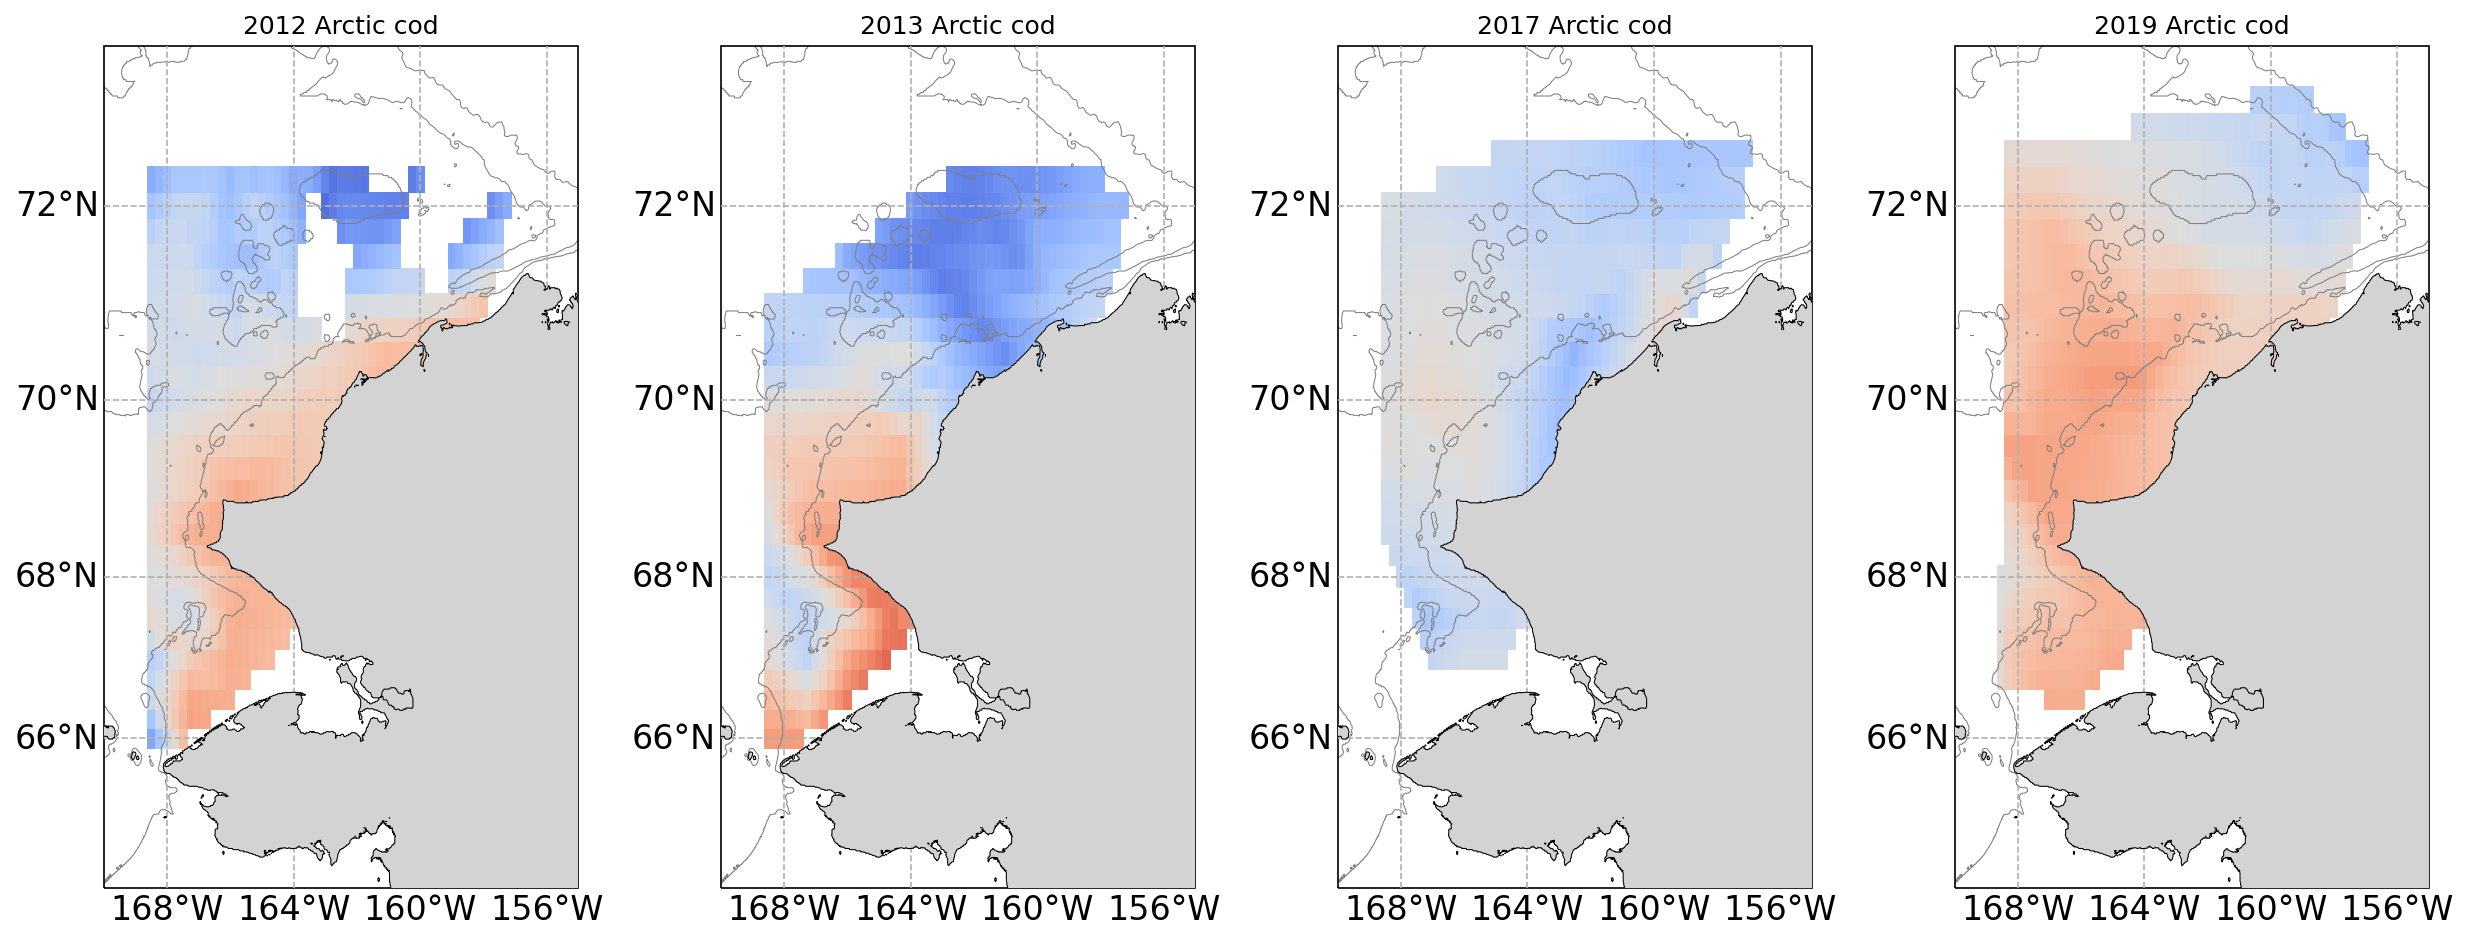

In [7]:
import sys
sys.path.insert(1, 'C:/Users/Robert/Documents/projects/rltools')
#sys.path.insert(1, 'C:/Users/robert.levine/work/repositories/rltools')
from akMaps import akMaps
mapper = akMaps.akMaps()
import cartopy.crs as ccrs
figure = plt.figure(figsize=(20,10),dpi=150)
ax=plt.subplot(141,projection=ccrs.Mercator())
mapper.chukchiMesh(dfStat2012.latitude,dfStat2012.longitude,dfStat2012.T_surf.values,cmin=-2,cmax=15,extent=[-155,-170,64,73.5],ax=ax)
ax.set_title('2012 Arctic cod')
ax=plt.subplot(142,projection=ccrs.Mercator())
mapper.chukchiMesh(dfStat2013.latitude,dfStat2013.longitude,dfStat2013.T_surf.values,cmin=-2,cmax=15,extent=[-155,-170,64,73.5],ax=ax)
ax.set_title('2013 Arctic cod')
ax=plt.subplot(143,projection=ccrs.Mercator())
mapper.chukchiMesh(dfStat2017.latitude,dfStat2017.longitude,dfStat2017.T_surf.values,cmin=-2,cmax=15,extent=[-155,-170,64,73.5],ax=ax)
ax.set_title('2017 Arctic cod')
ax=plt.subplot(144,projection=ccrs.Mercator())
mapper.chukchiMesh(dfStat2019.latitude,dfStat2019.longitude,dfStat2019.T_surf.values,cmin=-2,cmax=15,extent=[-155,-170,64,73.5],ax=ax)
ax.set_title('2019 Arctic cod')
plt.subplots_adjust(wspace=.3)

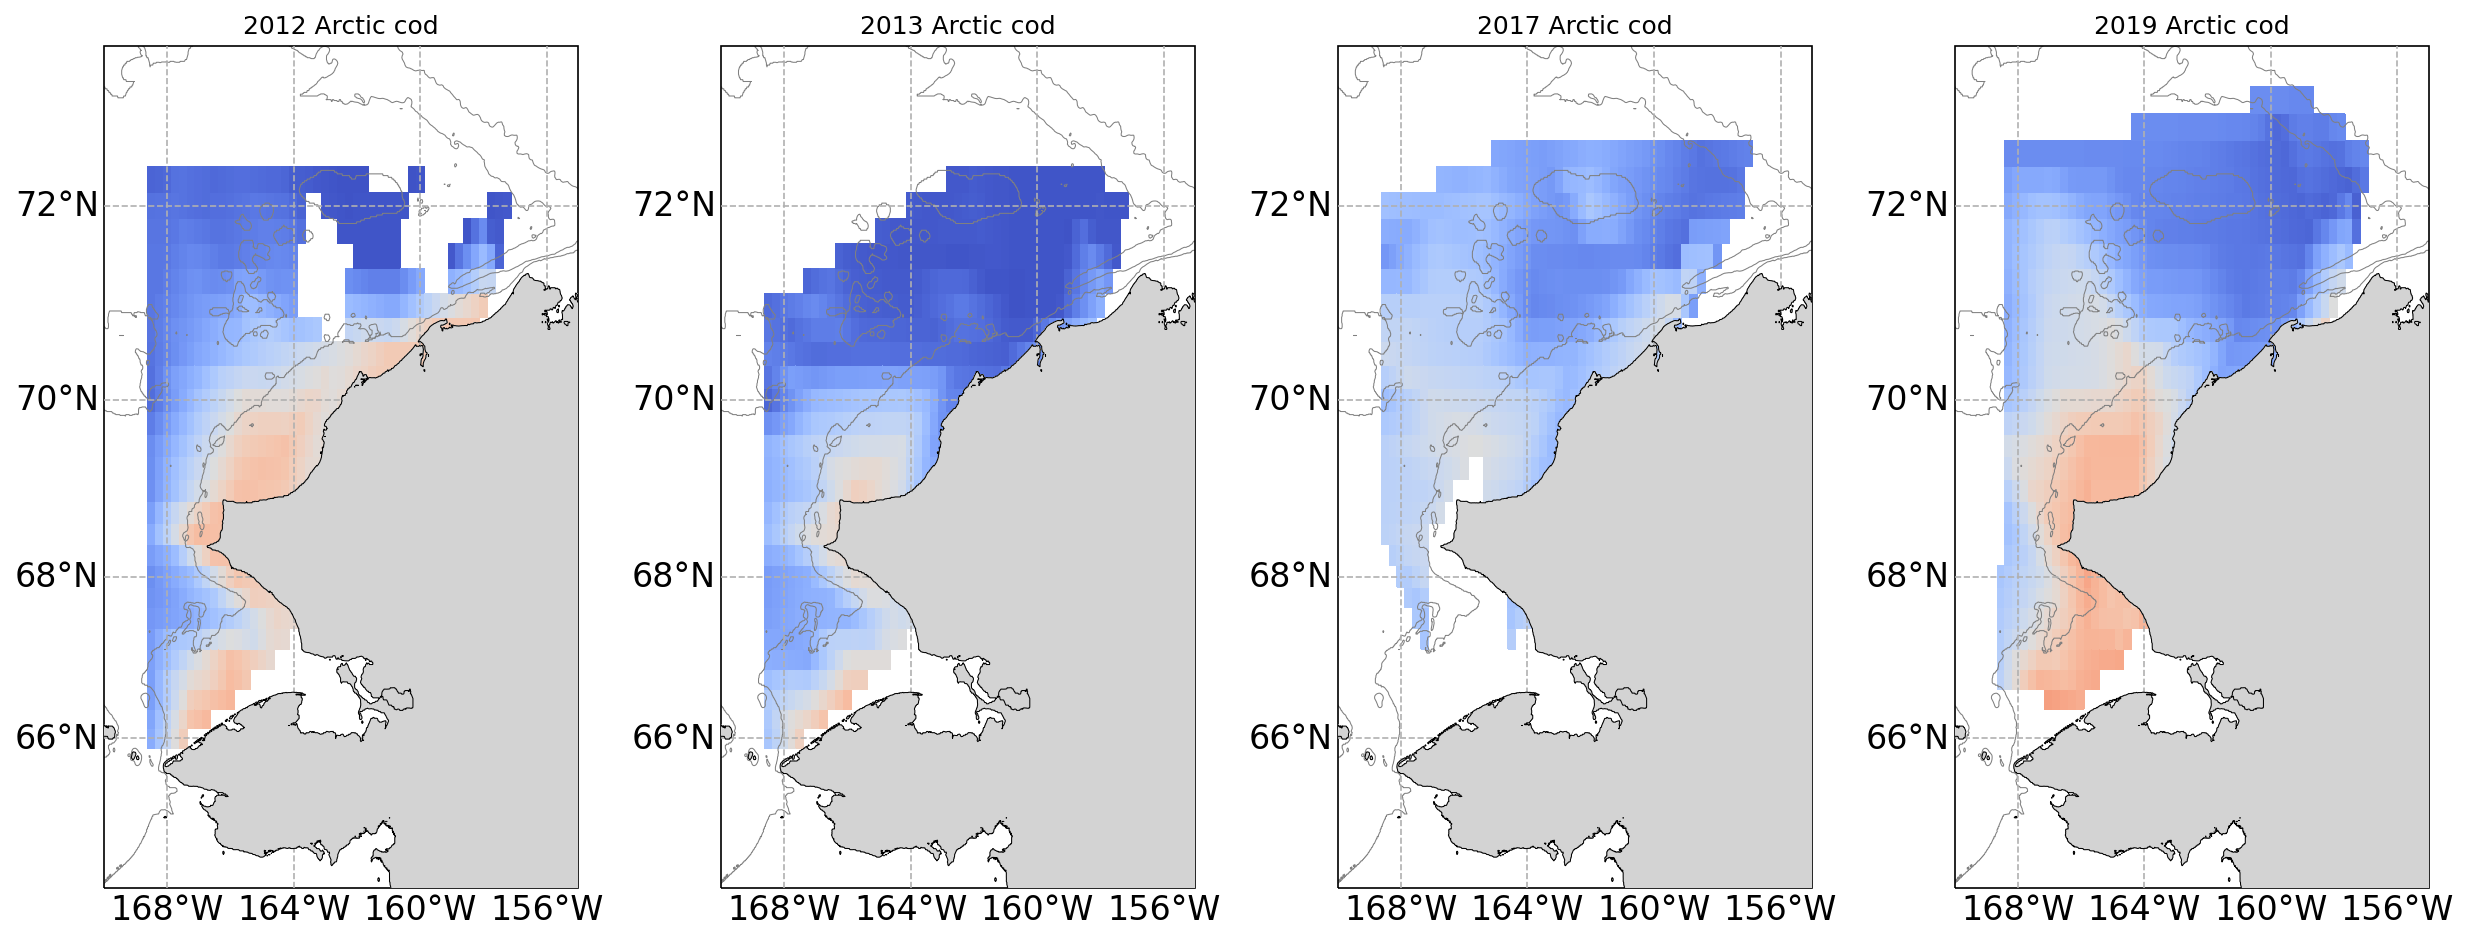

In [8]:
import sys
sys.path.insert(1, 'C:/Users/Robert/Documents/projects/rltools')
#sys.path.insert(1, 'C:/Users/robert.levine/work/repositories/rltools')
from akMaps import akMaps
mapper = akMaps.akMaps()
import cartopy.crs as ccrs
figure = plt.figure(figsize=(20,10),dpi=150)
ax=plt.subplot(141,projection=ccrs.Mercator())
mapper.chukchiMesh(dfStat2012.latitude,dfStat2012.longitude,dfStat2012.T_bot.values,cmin=-2,cmax=15,extent=[-155,-170,64,73.5],ax=ax)
ax.set_title('2012 Arctic cod')
ax=plt.subplot(142,projection=ccrs.Mercator())
mapper.chukchiMesh(dfStat2013.latitude,dfStat2013.longitude,dfStat2013.T_bot.values,cmin=-2,cmax=15,extent=[-155,-170,64,73.5],ax=ax)
ax.set_title('2013 Arctic cod')
ax=plt.subplot(143,projection=ccrs.Mercator())
mapper.chukchiMesh(dfStat2017.latitude,dfStat2017.longitude,dfStat2017.T_bot.values,cmin=-2,cmax=15,extent=[-155,-170,64,73.5],ax=ax)
ax.set_title('2017 Arctic cod')
ax=plt.subplot(144,projection=ccrs.Mercator())
mapper.chukchiMesh(dfStat2019.latitude,dfStat2019.longitude,dfStat2019.T_bot.values,cmin=-2,cmax=15,extent=[-155,-170,64,73.5],ax=ax)
ax.set_title('2019 Arctic cod')
plt.subplots_adjust(wspace=.3)

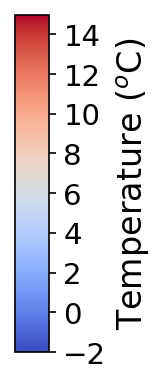

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(.25, 15),dpi=150)
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=-2, vmax=15)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
#cb1.set_label('Pollock m$^{-2}$',fontsize=16,labelpad=-15)
cb1.set_label('Temperature ($^{o}$C)',fontsize=16)
cb1.set_ticks([-2,0,2,4,6,8,10,12,14])
#cb1.set_ticklabels(['< .001','1','2','> 3'])
cb1.ax.tick_params(labelsize=14)

0.507183908045977
0.1856115107913669
0.1631663974151858
0.445679012345679


Text(0.5, 1.0, '>= 66 N')

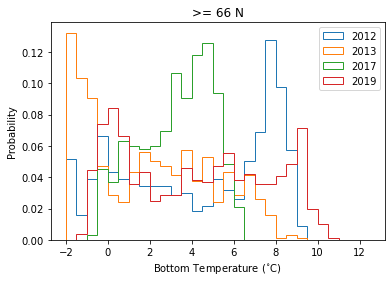

In [46]:
# Same method as chukchi_mesh in akMaps toolbox
from scipy.interpolate import griddata
for df in [dfStat2012,dfStat2013,dfStat2017,dfStat2019]:
    df = df[df.latitude >=66]
    lon = df.longitude.values
    lat = df.latitude.values
    values = df.T_bot.values
    grid_x, grid_y = np.mgrid[min(lon):max(lon):0.25, min(lat):max(lat):0.25]
    grid_z0 = griddata((lon,lat), values, (grid_x, grid_y), method='linear')
    temps = grid_z0.flatten()
    gT = temps[~np.isnan(temps)]
    weights = np.ones_like(gT) / len(gT)
    a = plt.hist(gT,bins=np.arange(-2,13,0.5),weights=weights,histtype = 'step', fill = None)
    print(len(gT[gT > 5])/len(gT))
    #print(np.mean(gT))
plt.legend(['2012','2013','2017','2019'])
plt.ylabel('Probability')
plt.xlabel('Bottom Temperature ($^{\circ}$C)')
plt.title('>= 66 N')

In [ ]:
import sys
sys.path.insert(1, 'C:/Users/Robert/Documents/projects/rltools')
#sys.path.insert(1, 'C:/Users/robert.levine/work/repositories/rltools')
from akMaps import akMaps
mapper = akMaps.akMaps()
mapper.chukchiMesh(dfStat2019.latitude.values,dfStat2019.longitude.values,dfStat2019.T_surf.values,cmin=-2,cmax=15,extent=[-155,-171,65.5,73.5],interpMethod='cubic')

(28.0, 35.0, -2.2, 11.5)

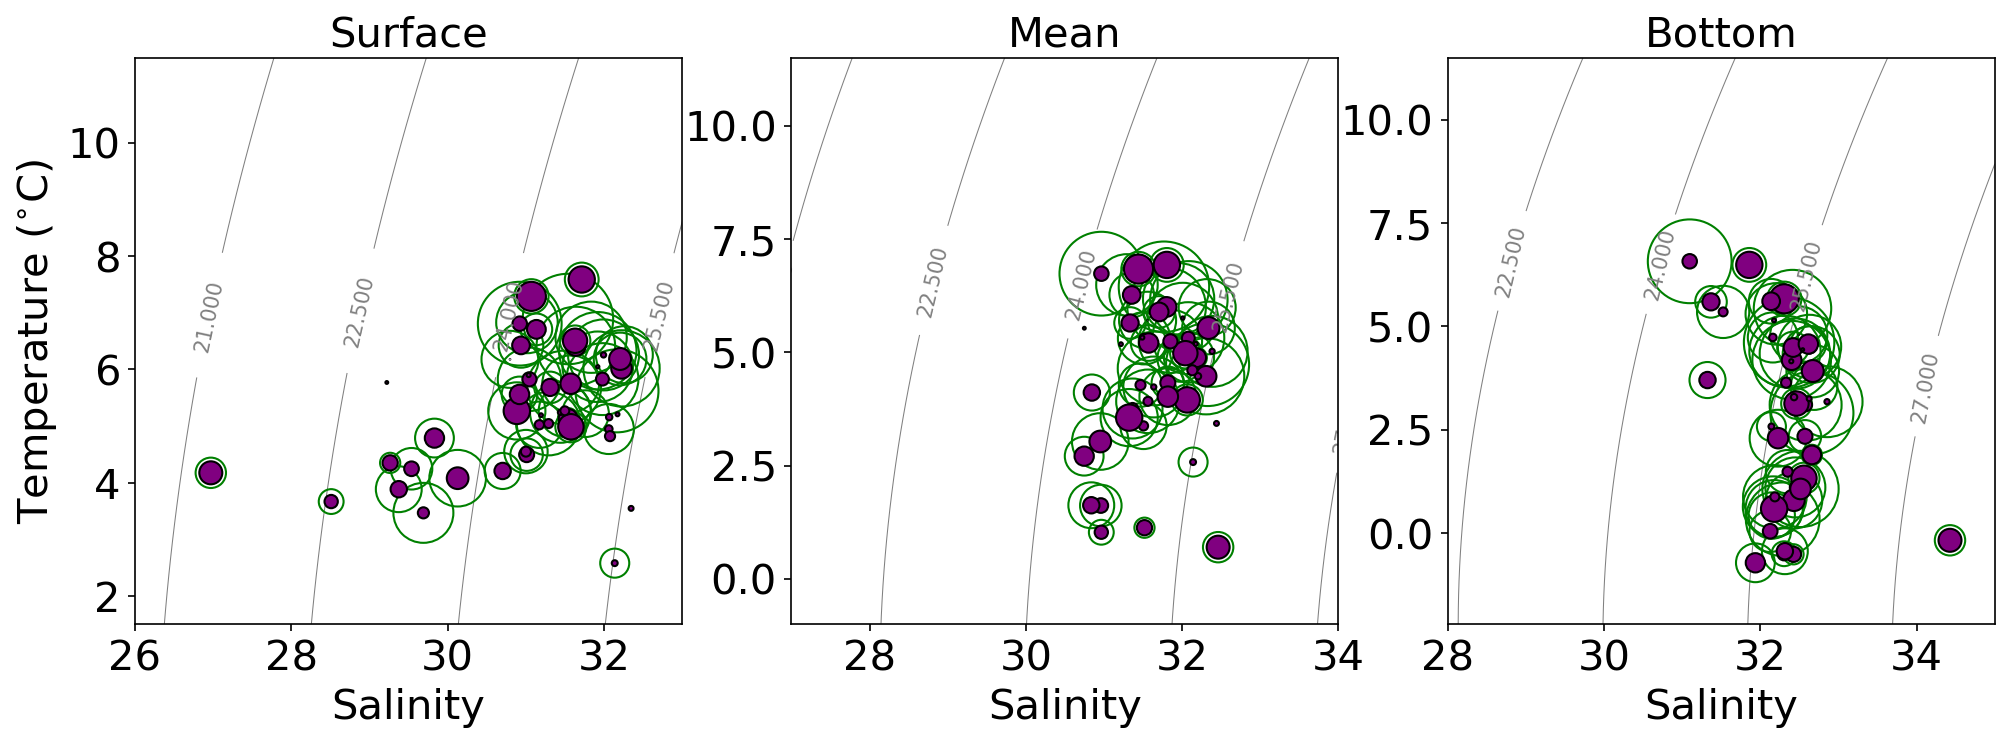

In [298]:
df = dfStat2017
from matplotlib.lines import Line2D
fig = plt.figure(figsize=(16,5),dpi=150)
ax=plt.subplot(131)
plt.scatter(df.S_surf,df.T_surf,s=(df.meanAcod*100),facecolors='none', edgecolors='green')
plt.scatter(df.S_surf,df.T_surf,s=(df.meanPol*100),facecolors='purple', edgecolors='k')
#plt.scatter(df.S_surf,df.T_surf,s=(df.meanScod*100),facecolors='none',edgecolors='r')
#plt.scatter(df.S_surf,df.T_surf,s=(df.meanPcod*100),facecolors='none',edgecolors='k')
plt.tick_params(labelsize=20)
plt.xlabel('Salinity',fontsize=20)
plt.ylabel('Temperature ($^{\circ}$C)',fontsize=20);
plt.title('Surface', fontsize=20)
x = np.linspace(25,35,50)
y = np.linspace(-1,14,50)
X, Y = np.meshgrid(x, y)
Z = gsw.density.sigma0(X, Y)
contours=plt.contour(X, Y, Z, colors='grey',zorder=0);
plt.clabel(contours,[18.,19.5, 21.,22.5, 24.,  25.5, 27.,  28.5])
plt.axis([26,33,1.5,11.5])

ax=plt.subplot(132)
plt.scatter(df.S_mean,df.T_mean,s=(df.meanAcod*100),facecolors='none', edgecolors='green')
plt.scatter(df.S_mean,df.T_mean,s=(df.meanPol*100),facecolors='purple', edgecolors='k')
#plt.scatter(df.S_mean,df.T_mean,s=(df.meanScod*100),facecolors='none',edgecolors='r')
#plt.scatter(df.S_mean,df.T_mean,s=(df.meanPcod*100),facecolors='none',edgecolors='k')
plt.tick_params(labelsize=20)
plt.xlabel('Salinity',fontsize=20)
#plt.ylabel('Temperature ($^{\circ}$C)',fontsize=20);
plt.title('Mean', fontsize=20)
x = np.linspace(25,35,50)
y = np.linspace(-2.5,14,50)
X, Y = np.meshgrid(x, y)
Z = gsw.density.sigma0(X, Y)
contours=plt.contour(X, Y, Z, colors='grey',zorder=0);
plt.clabel(contours,[18.,19.5, 21.,22.5, 24.,  25.5, 27.,  28.5])
plt.axis([27,34,-1,11.5])

ax=plt.subplot(133)
plt.scatter(df.S_bot,df.T_bot,s=(df.meanAcod*100),facecolors='none', edgecolors='green')
plt.scatter(df.S_bot,df.T_bot,s=(df.meanPol*100),facecolors='purple', edgecolors='k')
#plt.scatter(df.S_bot,df.T_bot,s=(df.meanScod*100),facecolors='none',edgecolors='r')
#plt.scatter(df.S_bot,df.T_bot,s=(df.meanPcod*100),facecolors='none',edgecolors='k')
plt.tick_params(labelsize=20)
plt.xlabel('Salinity',fontsize=20)
#plt.ylabel('Temperature ($^{\circ}$C)',fontsize=20);
plt.title('Bottom', fontsize=20)
x = np.linspace(25,35,50)
y = np.linspace(-2.5,14,50)
X, Y = np.meshgrid(x, y)
Z = gsw.density.sigma0(X, Y)
contours=plt.contour(X, Y, Z, colors='grey',zorder=0);
plt.clabel(contours,[18.,19.5, 21.,22.5, 24.,  25.5, 27.,  28.5])
plt.axis([28,35,-2.2,11.5])

(28.0, 35.0, -2.2, 11.5)

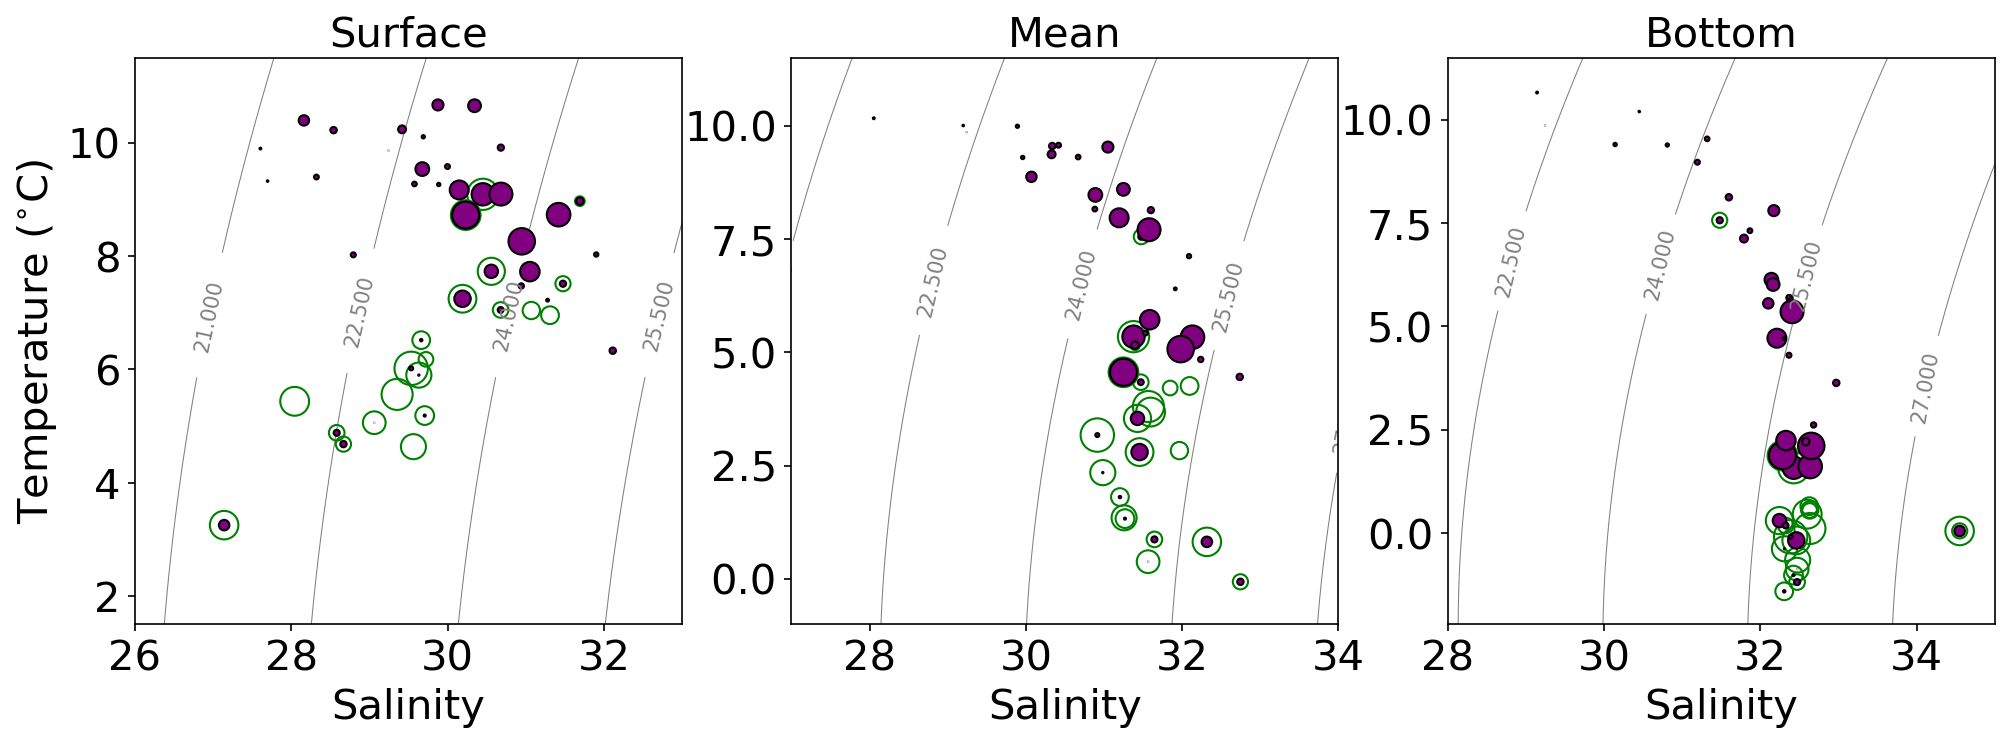

In [23]:
df = dfStat2019
from matplotlib.lines import Line2D
fig = plt.figure(figsize=(16,5),dpi=150)
ax=plt.subplot(131)
plt.scatter(df.S_surf,df.T_surf,s=(df.meanAcod*100),facecolors='none', edgecolors='green')
plt.scatter(df.S_surf,df.T_surf,s=(df.meanPol*100),facecolors='purple', edgecolors='k')
#plt.scatter(df.S_surf,df.T_surf,s=(df.meanScod*100),facecolors='none',edgecolors='r')
#plt.scatter(df.S_surf,df.T_surf,s=(df.meanPcod*100),facecolors='none',edgecolors='k')
plt.tick_params(labelsize=20)
plt.xlabel('Salinity',fontsize=20)
plt.ylabel('Temperature ($^{\circ}$C)',fontsize=20);
plt.title('Surface', fontsize=20)
x = np.linspace(25,35,50)
y = np.linspace(-1,14,50)
X, Y = np.meshgrid(x, y)
Z = gsw.density.sigma0(X, Y)
contours=plt.contour(X, Y, Z, colors='grey',zorder=0);
plt.clabel(contours,[18.,19.5, 21.,22.5, 24.,  25.5, 27.,  28.5])
plt.axis([26,33,1.5,11.5])

ax=plt.subplot(132)
plt.scatter(df.S_mean,df.T_mean,s=(df.meanAcod*100),facecolors='none', edgecolors='green')
plt.scatter(df.S_mean,df.T_mean,s=(df.meanPol*100),facecolors='purple', edgecolors='k')
#plt.scatter(df.S_mean,df.T_mean,s=(df.meanScod*100),facecolors='none',edgecolors='r')
#plt.scatter(df.S_mean,df.T_mean,s=(df.meanPcod*100),facecolors='none',edgecolors='k')
plt.tick_params(labelsize=20)
plt.xlabel('Salinity',fontsize=20)
#plt.ylabel('Temperature ($^{\circ}$C)',fontsize=20);
plt.title('Mean', fontsize=20)
x = np.linspace(25,35,50)
y = np.linspace(-2.5,14,50)
X, Y = np.meshgrid(x, y)
Z = gsw.density.sigma0(X, Y)
contours=plt.contour(X, Y, Z, colors='grey',zorder=0);
plt.clabel(contours,[18.,19.5, 21.,22.5, 24.,  25.5, 27.,  28.5])
plt.axis([27,34,-1,11.5])

ax=plt.subplot(133)
plt.scatter(df.S_bot,df.T_bot,s=(df.meanAcod*100),facecolors='none', edgecolors='green')
plt.scatter(df.S_bot,df.T_bot,s=(df.meanPol*100),facecolors='purple', edgecolors='k')
#plt.scatter(df.S_bot,df.T_bot,s=(df.meanScod*100),facecolors='none',edgecolors='r')
#plt.scatter(df.S_bot,df.T_bot,s=(df.meanPcod*100),facecolors='none',edgecolors='k')
plt.tick_params(labelsize=20)
plt.xlabel('Salinity',fontsize=20)
#plt.ylabel('Temperature ($^{\circ}$C)',fontsize=20);
plt.title('Bottom', fontsize=20)
x = np.linspace(25,35,50)
y = np.linspace(-2.5,14,50)
X, Y = np.meshgrid(x, y)
Z = gsw.density.sigma0(X, Y)
contours=plt.contour(X, Y, Z, colors='grey',zorder=0);
plt.clabel(contours,[18.,19.5, 21.,22.5, 24.,  25.5, 27.,  28.5])
plt.axis([28,35,-2.2,11.5])

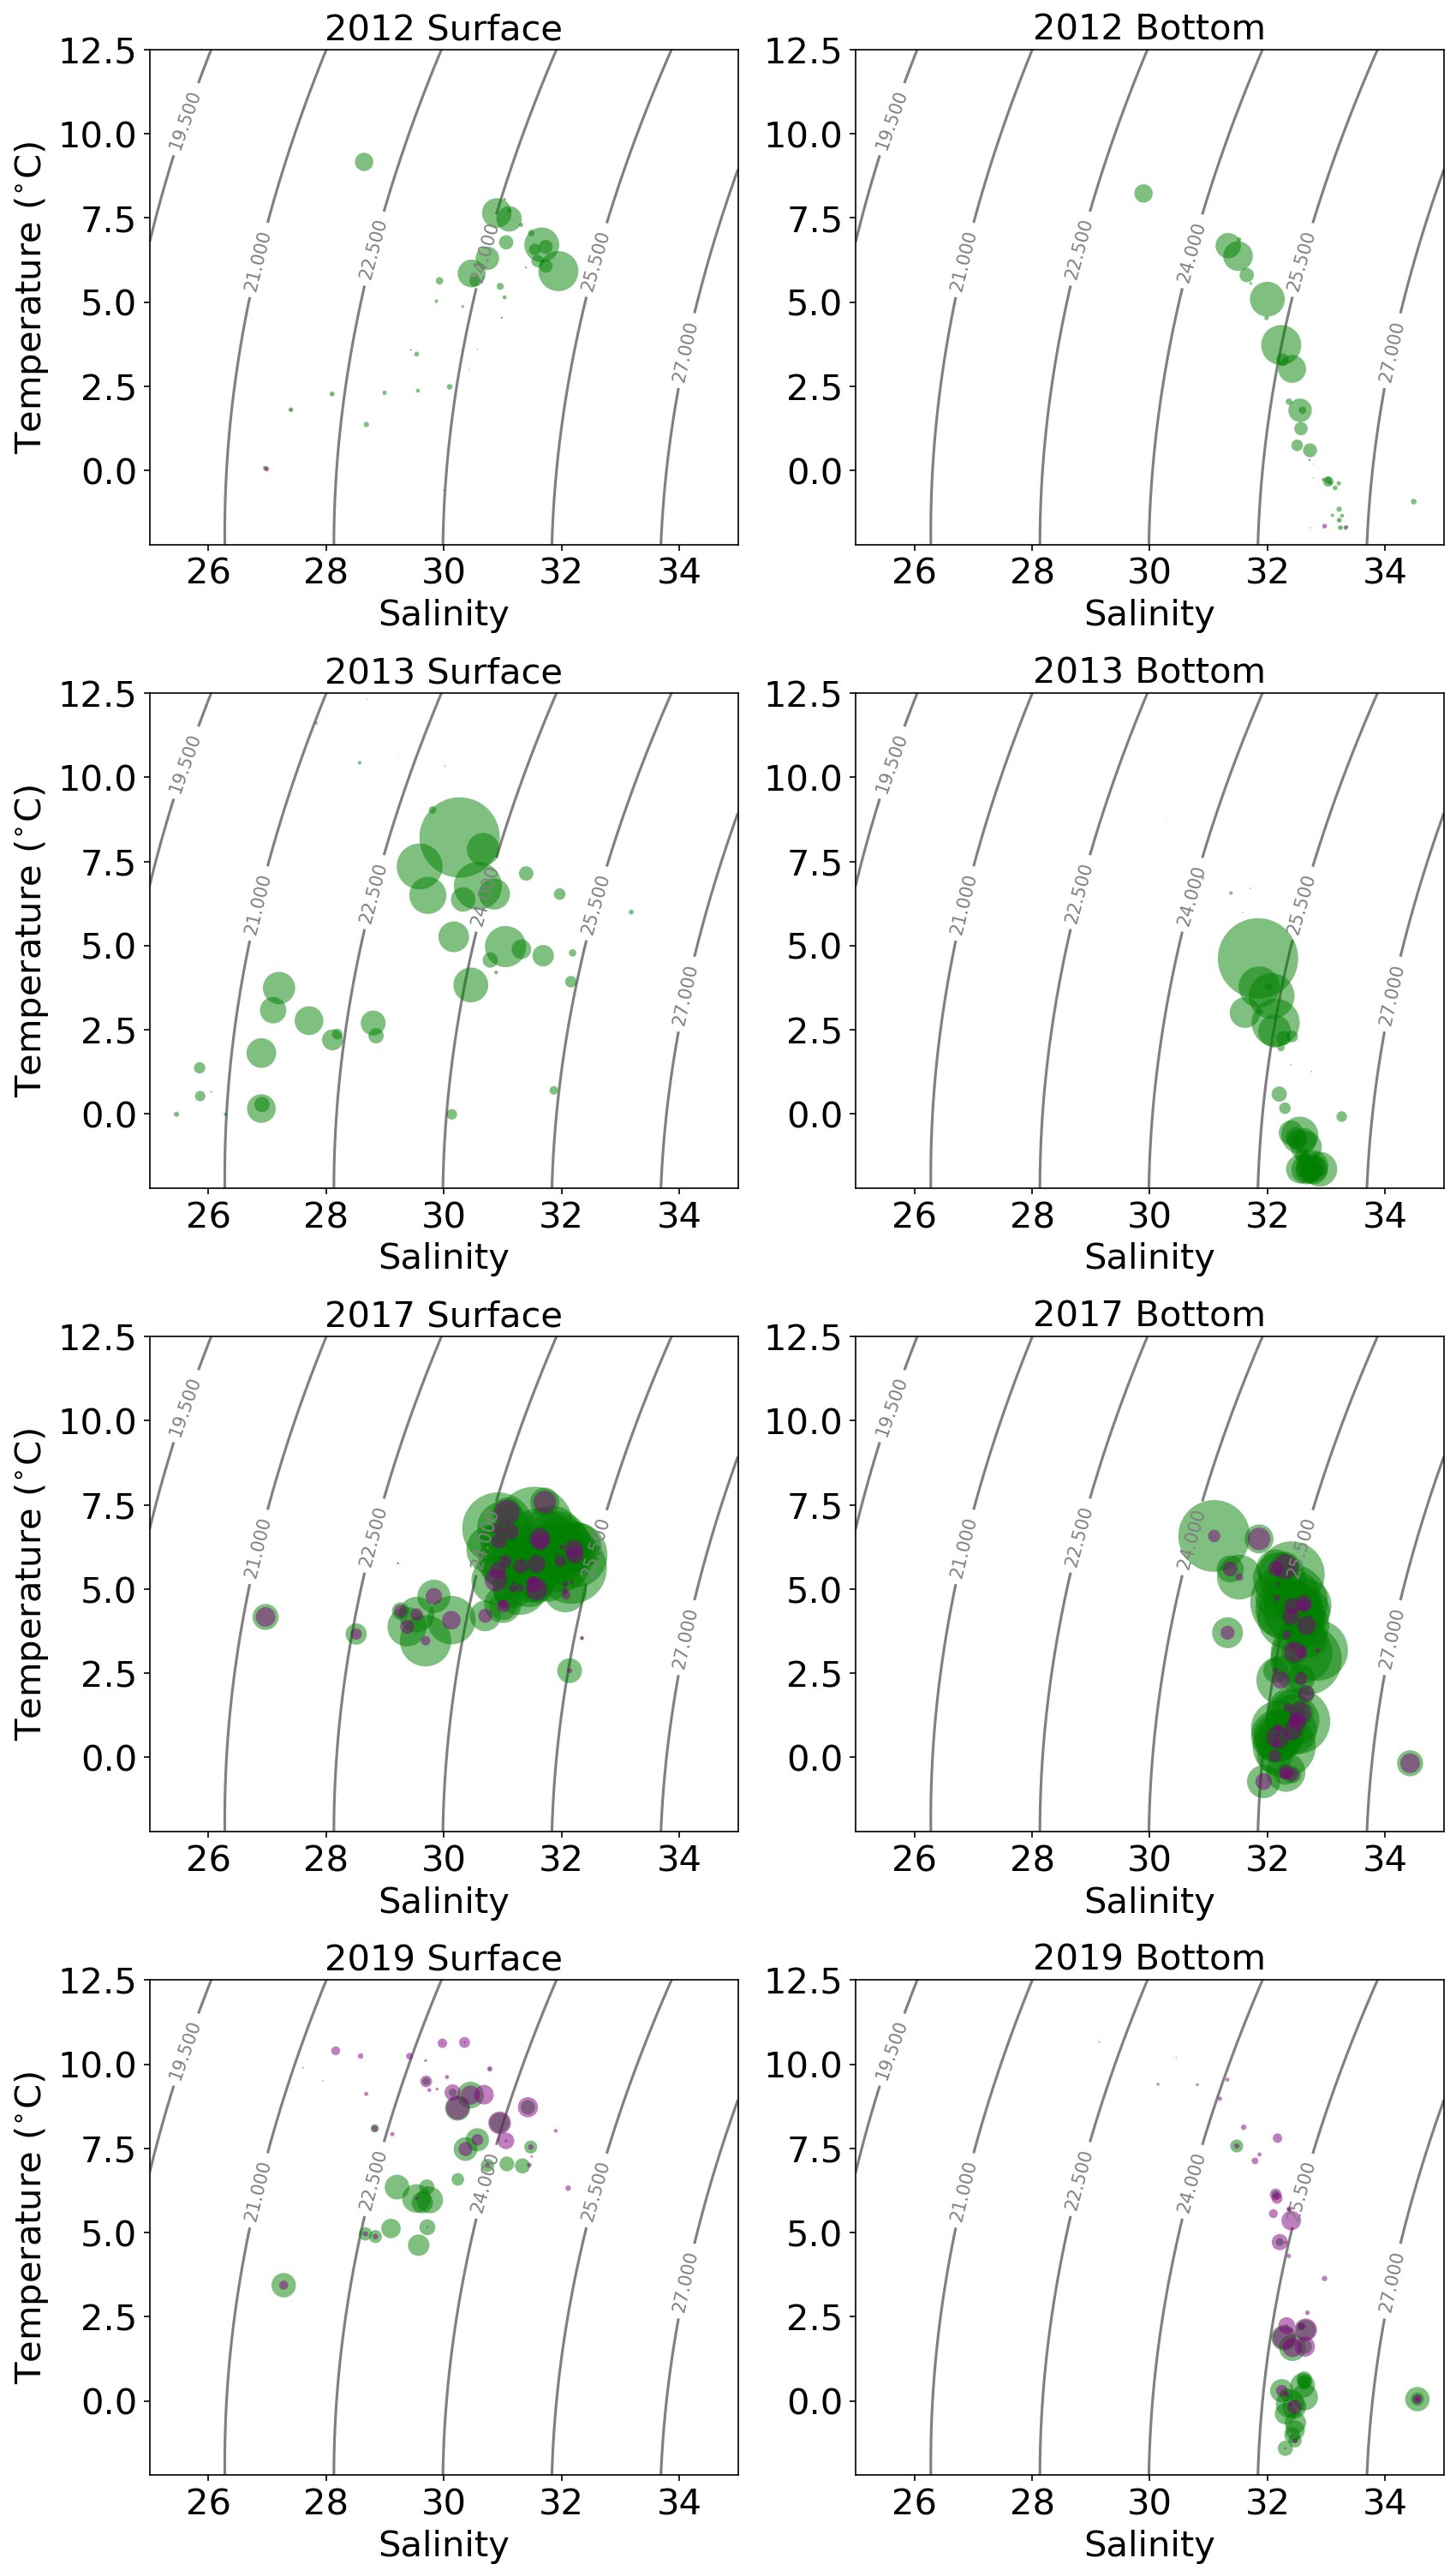

In [10]:
from matplotlib.lines import Line2D
fig = plt.figure(figsize=(13,25),dpi=150)

df = dfStat2012
ax=plt.subplot(421)
plt.scatter(df.S_surf,df.T_surf,s=(df.meanAcod*100),facecolors='green', edgecolors='none',alpha=0.5)
plt.scatter(df.S_surf,df.T_surf,s=(df.meanPol*100),facecolors='purple', edgecolors='none',alpha=0.5)
#plt.scatter(df.S_surf,df.T_surf,s=(df.meanScod*100),facecolors='none',edgecolors='r')
#plt.scatter(df.S_surf,df.T_surf,s=(df.meanPcod*100),facecolors='none',edgecolors='k')
plt.tick_params(labelsize=20)
plt.xlabel('Salinity',fontsize=20)
plt.ylabel('Temperature ($^{\circ}$C)',fontsize=20);
plt.title('2012 Surface', fontsize=20)
x = np.linspace(25,35,50)
y = np.linspace(-2.5,14,50)
X, Y = np.meshgrid(x, y)
Z = gsw.density.sigma0(X, Y)
contours=plt.contour(X, Y, Z, colors='grey',zorder=0);
plt.clabel(contours,[18.,19.5, 21.,22.5, 24.,  25.5, 27.,  28.5])
plt.axis([25,35,-2.2,12.5])

ax=plt.subplot(422)
plt.scatter(df.S_bot,df.T_bot,s=(df.meanAcod*100),facecolors='green', edgecolors='none',alpha=0.5)
plt.scatter(df.S_bot,df.T_bot,s=(df.meanPol*100),facecolors='purple', edgecolors='none',alpha=0.5)
#plt.scatter(df.S_bot,df.T_bot,s=(df.meanScod*100),facecolors='none',edgecolors='r')
#plt.scatter(df.S_bot,df.T_bot,s=(df.meanPcod*100),facecolors='none',edgecolors='k')
plt.tick_params(labelsize=20)
plt.xlabel('Salinity',fontsize=20)
#plt.ylabel('Temperature ($^{\circ}$C)',fontsize=20);
plt.title('2012 Bottom', fontsize=20)
x = np.linspace(25,35,50)
y = np.linspace(-2.5,14,50)
X, Y = np.meshgrid(x, y)
Z = gsw.density.sigma0(X, Y)
contours=plt.contour(X, Y, Z, colors='grey',zorder=0);
plt.clabel(contours,[18.,19.5, 21.,22.5, 24.,  25.5, 27.,  28.5])
plt.axis([25,35,-2.2,12.5])

df = dfStat2013
ax=plt.subplot(423)
plt.scatter(df.S_surf,df.T_surf,s=(df.meanAcod*100),facecolors='green', edgecolors='none',alpha=0.5)
plt.scatter(df.S_surf,df.T_surf,s=(df.meanPol*100),facecolors='purple', edgecolors='none',alpha=0.5)
#plt.scatter(df.S_surf,df.T_surf,s=(df.meanScod*100),facecolors='none',edgecolors='r')
#plt.scatter(df.S_surf,df.T_surf,s=(df.meanPcod*100),facecolors='none',edgecolors='k')
plt.tick_params(labelsize=20)
plt.xlabel('Salinity',fontsize=20)
plt.ylabel('Temperature ($^{\circ}$C)',fontsize=20);
plt.title('2013 Surface', fontsize=20)
x = np.linspace(25,35,50)
y = np.linspace(-2.5,14,50)
X, Y = np.meshgrid(x, y)
Z = gsw.density.sigma0(X, Y)
contours=plt.contour(X, Y, Z, colors='grey',zorder=0);
plt.clabel(contours,[18.,19.5, 21.,22.5, 24.,  25.5, 27.,  28.5])
plt.axis([25,35,-2.2,12.5])

ax=plt.subplot(424)
plt.scatter(df.S_bot,df.T_bot,s=(df.meanAcod*100),facecolors='green', edgecolors='none',alpha=0.5)
plt.scatter(df.S_bot,df.T_bot,s=(df.meanPol*100),facecolors='purple', edgecolors='none',alpha=0.5)
#plt.scatter(df.S_bot,df.T_bot,s=(df.meanScod*100),facecolors='none',edgecolors='r')
#plt.scatter(df.S_bot,df.T_bot,s=(df.meanPcod*100),facecolors='none',edgecolors='k')
plt.tick_params(labelsize=20)
plt.xlabel('Salinity',fontsize=20)
#plt.ylabel('Temperature ($^{\circ}$C)',fontsize=20);
plt.title('2013 Bottom', fontsize=20)
x = np.linspace(25,35,50)
y = np.linspace(-2.5,14,50)
X, Y = np.meshgrid(x, y)
Z = gsw.density.sigma0(X, Y)
contours=plt.contour(X, Y, Z, colors='grey',zorder=0);
plt.clabel(contours,[18.,19.5, 21.,22.5, 24.,  25.5, 27.,  28.5])
plt.axis([25,35,-2.2,12.5])

df = dfStat2017
ax=plt.subplot(425)
plt.scatter(df.S_surf,df.T_surf,s=(df.meanAcod*100),facecolors='green', edgecolors='none',alpha=0.5)
plt.scatter(df.S_surf,df.T_surf,s=(df.meanPol*100),facecolors='purple', edgecolors='none',alpha=0.5)
#plt.scatter(df.S_surf,df.T_surf,s=(df.meanScod*100),facecolors='none',edgecolors='r')
#plt.scatter(df.S_surf,df.T_surf,s=(df.meanPcod*100),facecolors='none',edgecolors='k')
plt.tick_params(labelsize=20)
plt.xlabel('Salinity',fontsize=20)
plt.ylabel('Temperature ($^{\circ}$C)',fontsize=20);
plt.title('2017 Surface', fontsize=20)
x = np.linspace(25,35,50)
y = np.linspace(-2.5,14,50)
X, Y = np.meshgrid(x, y)
Z = gsw.density.sigma0(X, Y)
contours=plt.contour(X, Y, Z, colors='grey',zorder=0);
plt.clabel(contours,[18.,19.5, 21.,22.5, 24.,  25.5, 27.,  28.5])
plt.axis([25,35,-2.2,12.5])

ax=plt.subplot(426)
plt.scatter(df.S_bot,df.T_bot,s=(df.meanAcod*100),facecolors='green', edgecolors='none',alpha=0.5)
plt.scatter(df.S_bot,df.T_bot,s=(df.meanPol*100),facecolors='purple', edgecolors='none',alpha=0.5)
#plt.scatter(df.S_bot,df.T_bot,s=(df.meanScod*100),facecolors='none',edgecolors='r')
#plt.scatter(df.S_bot,df.T_bot,s=(df.meanPcod*100),facecolors='none',edgecolors='k')
plt.tick_params(labelsize=20)
plt.xlabel('Salinity',fontsize=20)
#plt.ylabel('Temperature ($^{\circ}$C)',fontsize=20);
plt.title('2017 Bottom', fontsize=20)
x = np.linspace(25,35,50)
y = np.linspace(-2.5,14,50)
X, Y = np.meshgrid(x, y)
Z = gsw.density.sigma0(X, Y)
contours=plt.contour(X, Y, Z, colors='grey',zorder=0);
plt.clabel(contours,[18.,19.5, 21.,22.5, 24.,  25.5, 27.,  28.5])
plt.axis([25,35,-2.2,12.5])

df = dfStat2019
ax=plt.subplot(427)
plt.scatter(df.S_surf,df.T_surf,s=(df.meanAcod*100),facecolors='green', edgecolors='none',alpha=0.5)
plt.scatter(df.S_surf,df.T_surf,s=(df.meanPol*100),facecolors='purple', edgecolors='none',alpha=0.5)
#plt.scatter(df.S_surf,df.T_surf,s=(df.meanScod*100),facecolors='none',edgecolors='r')
#plt.scatter(df.S_surf,df.T_surf,s=(df.meanPcod*100),facecolors='none',edgecolors='k')
plt.tick_params(labelsize=20)
plt.xlabel('Salinity',fontsize=20)
plt.ylabel('Temperature ($^{\circ}$C)',fontsize=20);
plt.title('2019 Surface', fontsize=20)
x = np.linspace(25,35,50)
y = np.linspace(-2.5,14,50)
X, Y = np.meshgrid(x, y)
Z = gsw.density.sigma0(X, Y)
contours=plt.contour(X, Y, Z, colors='grey',zorder=0);
plt.clabel(contours,[18.,19.5, 21.,22.5, 24.,  25.5, 27.,  28.5])
plt.axis([25,35,-2.2,12.5])

ax=plt.subplot(428)
plt.scatter(df.S_bot,df.T_bot,s=(df.meanAcod*100),facecolors='green', edgecolors='none',alpha=0.5)
plt.scatter(df.S_bot,df.T_bot,s=(df.meanPol*100),facecolors='purple', edgecolors='none',alpha=0.5)
#plt.scatter(df.S_bot,df.T_bot,s=(df.meanScod*100),facecolors='none',edgecolors='r')
#plt.scatter(df.S_bot,df.T_bot,s=(df.meanPcod*100),facecolors='none',edgecolors='k')
plt.tick_params(labelsize=20)
plt.xlabel('Salinity',fontsize=20)
#plt.ylabel('Temperature ($^{\circ}$C)',fontsize=20);
plt.title('2019 Bottom', fontsize=20)
x = np.linspace(25,35,50)
y = np.linspace(-2.5,14,50)
X, Y = np.meshgrid(x, y)
Z = gsw.density.sigma0(X, Y)
contours=plt.contour(X, Y, Z, colors='grey',zorder=0);
plt.clabel(contours,[18.,19.5, 21.,22.5, 24.,  25.5, 27.,  28.5])
plt.axis([25,35,-2.2,12.5])
plt.subplots_adjust(hspace=0.3,wspace=0.2)

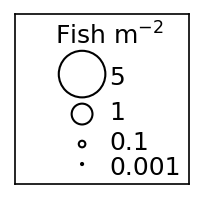

In [331]:
plt.figure(figsize=(1.5,1.5),dpi=150)
plt.scatter(27,7,.01*100,facecolors='none', edgecolors='k')
plt.scatter(27,7.2,.1*100,facecolors='none', edgecolors='k')
plt.scatter(27,7.5,1*100,facecolors='none', edgecolors='k')
plt.scatter(27,7.9,5*100,facecolors='none', edgecolors='k')
plt.text(26.8,8.2,'Fish m$^{-2}$',fontsize=12)
plt.text(27.2,6.9,'0.001',fontsize=12)
plt.text(27.2,7.15,'0.1',fontsize=12)
plt.text(27.2,7.45,'1',fontsize=12)
plt.text(27.2,7.8,'5',fontsize=12)
plt.axis([26.5,27.8,6.8,8.5])
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off